# Линейная классификация: общий подход. SVM.

Повторим определение задачи классификации. 

Задача классификации на $N$ классов == построить отображение $a(\overline{x}) = C$, где $\overline{x}$ - описание объекта, $C \in \{1, ..., N\}$ - класс объекта.

Продолжим изучать класс линейных классификаторов в задаче бинарной классификации ($N = 2, \{0, 1\}$).

Как мы помним, основная идея линейного классификатора заключается в том, что признаковое пространство может быть разделено гиперплоскостью на два полупространства, в каждом из которых прогнозируется одно из двух значений целевого класса.

Заметим, что таких гиперплоскостей существует очень много (~континуум):

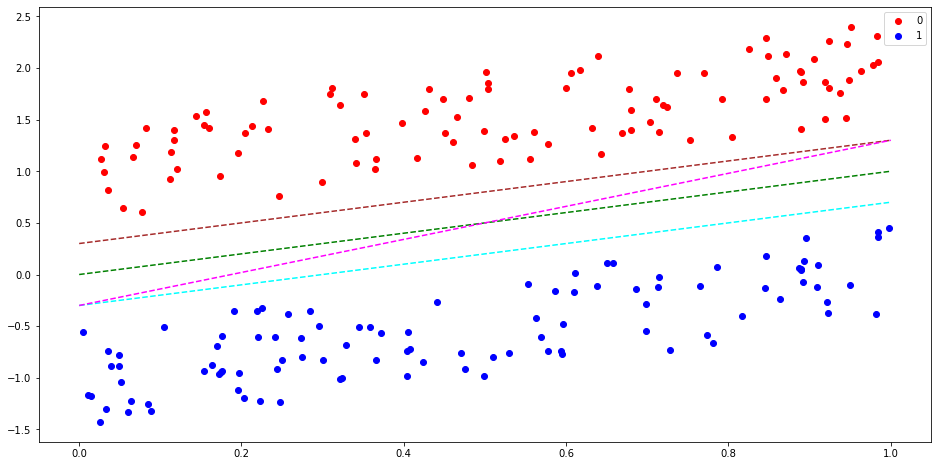

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

N = 200
xs = np.random.rand(N)
ys = []

for x in xs[:N // 2]:
    ys.append(x + np.random.rand() + 0.5)
    
for x in xs[N // 2:]:
    ys.append(x - np.random.rand() - 0.5)
    
plt.figure(figsize=(16, 8))
plt.scatter(xs[:N // 2], ys[:N // 2], color="red", label="0")
plt.scatter(xs[N // 2:], ys[N // 2:], color="blue", label="1")
plt.plot([0, 1], [0, 1], "--", color="green")
plt.plot([0, 1], [-0.3, 0.7], "--", color="cyan")
plt.plot([0, 1], [0.3, 1.3], "--", color="brown")
plt.plot([0, 1], [-0.3, 1.3], "--", color="magenta")
plt.legend()
plt.show()

**Вопрос:** а как нам выбрать гиперплоскость?

Давайте вспомним основную идею линейной классификации: 

$a(x) = sign(w^Tx - b)$, где $w$ - векторо весов, $b$ - смещение, $x$ - вектор признаков, $sign(*)$ - функция, возвращающая знак числа $\{-1, +1\}$

Основная идея SVM (Support Vector Machine): веса $w$ настраиваются таким образом, чтобы объекты классов лежали как можно дальше от разделяющей гиперплоскости, то есть алгоритм максимизирует зазор (англ. margin) между гиперплоскостью и объектами классов, которые расположены ближе всего к ней. Такие объекты и называют опорными векторами.

<img src="svm.jpg" alt="Drawing" style="width: 400px;">
(картинка взята [отсюда](https://staesthetic.files.wordpress.com/2014/02/svm.png?w=1060))

## Линейно разделимые выборки 

* Параметры линейного порогового классификатора определены с точностью до нормировки.
* Пусть множество точек $x: \{ -1 < wx + b < 1\}$ описывает полосу, разделяющую классы. 
* Ни один из объектов обучающей выборки не лежит внутри этой полосы. 
* Границами полосы служат две параллельные гиперплоскости с вектором нормали w. 
* Разделяющая гиперплоскость проходит ровно по середине между ними. 


Как сделать так, чтобы разделяющая гиперплоскость как можно дальше отстояла от точек выборки?

Для этого найдем проекцию вектора, концами которого будут являться опорные вектора разных классов на вектор $w$. Эта проекция и будет показывать ширину разделяющий полосы.

$$\langle (x_{+} - x_{-}), \frac{w}{\|w\|} \rangle = \frac{\langle x_{+}, w\rangle - \langle x_{-}, w \rangle}{\|w\|} = \frac{(b + 1) - (b - 1)}{\|w\|} = \frac{2}{\|w\|}$$

Соответственно, так как мы хотим максимизировать зазор, нам нужно: $\frac{2}{\|w\|} \rightarrow \max$ или $\frac{w^Tw}{2} \rightarrow \min$

Зазором объекта $x$ от границы классов называется величина $M = y(w^Tx - b)$. (Переделали "+" на "-" относительно картинки, но, как мы знаем, качественно ничего не изменилось).

Каким должен быть зазор, чтобы объект классифицировался правильно?

* $M < 0$ - ошибка классификатора.
* $M \in (0, 1)$ - неуверенный ответ.
* $M \ge 1$ - все хорошо.

Алгоритм будет правильно классифицировать объекты, если выполняется условие:
$$ y(w^Tx - b) \ge 1$$

Таким образом, получаем задачу условной оптимизации:
$$
\begin{cases}
    \frac{w^Tw}{2} \rightarrow \min\\
    y(w^Tx - b) \ge 1
 \end{cases}
$$

Получили дефолтную настройку SVM с жестким зазором (hard-margin SVM), когда никакому объекту не разрешается попадать на полосу разделения.

**А что если классы линейно неразделимы?**

## Линейно неразделимая выборка

Надо как-то позволить алгоритму допускать ошибки на обучающих объектах, но при этом не "переусердствовать".

Для этого введём набор дополнительных переменных $\xi_i$, характеризующих величину ошибки на каждом объекте $x_i$. Введём в минимизируемый функционал штраф за суммарную ошибку:

$$
\begin{cases}
    \frac{w^Tw}{2} + \alpha \sum \xi_i \rightarrow \min\\
    y(w^Tx_i - b) \ge 1 - \xi_i\\
    \xi_i \ge 0
 \end{cases}
$$

Положительная константа $\alpha$ является управляющим параметром метода и позволяет находить баланс между максимизацией ширины разделяющей полосы и минимизацией суммарной ошибки.

Поставленную выше задачу неплохо было бы привести к задаче безусловной оптимизации. Попробуем это сделать.

Введем понятие штрафа - $Penalty$:
$$Penalty = \sum \left[M_i < 0\right] \text{- штраф,}$$ 
$$\left[M_i < 0\right] \text{- индикаторная функция}$$
$$Penalty = \sum \left[M_i < 0\right] \le \sum {\left(1 - M_i\right)}_{+} = \sum max\left(0, \left(1 - M_i\right)\right)$$ - (спойлер HingeLoss)

А теперь рассмотрим следующее:
$$
\xi_i \geq 0, \xi_i \geq 1 - M_i
$$
В силу требования минимизации суммы $\sum \xi_i$ одно из этих неравенств обратищается в равенство. Следовательно, $\xi_i = (1 − M_i)_+$ и:
$$
\mathcal{L} = \frac{w^Tw}{2\alpha} + \sum {\left(1 - M_i\right)}_{+} \rightarrow min
$$

$\mathcal{L}$ - функция потерь! 

Так как $\left[M_i < 0\right] \le {\left(1 - M_i\right)}_{+}$ - то функция потерь - верхняя оценка эмпирического риска $\sum \left[M_i < 0\right]$ + регуляризация.

Функцию потерь будем минимизировать с помощью градиентного спуска. 

Выведем правила изменения весов, где $\theta$ – шаг спуска:
$$
\begin{equation}
w^{i+1} = w^{i} - \theta \nabla_{w} \mathcal{L} \\
\nabla_{w} \mathcal{L} = 
\begin{cases}
    \frac{1}{\alpha}w - yx &\text{, при } yw^Tx < 1\\
    \frac{1}{\alpha}w & \text{, при } yw^Tx \ge 1
 \end{cases}
\end{equation}
$$

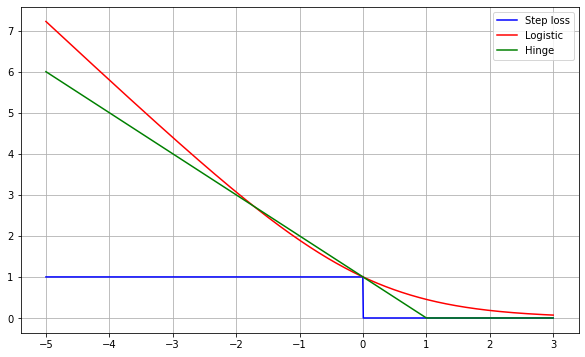

In [5]:
import numpy as np

hinge_loss = lambda x: np.maximum(1 - x, 0)
logistic_loss = lambda x: np.log2(1 + np.exp(-x))
step_loss = lambda x: (x < 0).astype(int)

xs = np.linspace(-5, 3, 1000)

plt.figure(figsize=(10, 6))
plt.plot(xs, step_loss(xs), color="blue", label="Step loss")
plt.plot(xs, logistic_loss(xs), color="red", label="Logistic")
plt.plot(xs, hinge_loss(xs), color="green", label="Hinge")
plt.grid()
plt.legend()
plt.show()

## Двойственная задача

Запишем функцию Лагранжа задачи для общей задачи линейно неразделимой выборки:
$$
L(w, b, \xi; \lambda, \eta) = \frac{\|w\|^2}{2} + \alpha \sum \xi_i - \sum \lambda_i (M_i − 1 + \xi) + \sum \eta_i \xi_i =
\frac{\|w\|^2}{2} - \sum \lambda_i (M_i - 1) - \sum \xi_i (\lambda_i + \eta_i - \alpha)
$$
, где $\lambda = (\lambda_1, ..., \lambda_l)$ — вектор переменных, двойственных к $w$; $\eta = (\eta_1, ..., \eta_l)$ — вектор
переменных, двойственных к $\xi = (\xi_1, ..., \xi_l)$.
Построим эквивалентную двойственную задачу, согласно теореме Куна-Таккера (поиск седловой точки функции Лагранжа):
$$
\begin{cases}
    L(w, b, \xi; \lambda, \eta) \rightarrow \min_{w,b,\xi} \max_{\lambda,\eta}\\
    \xi_i \geq 0, \lambda_i \geq 0, \eta_i \geq 0;\\
    \lambda_i = 0 \text{ либо } M_i = 1 - \xi_i\\
    \eta_i = 0 \text{ либо } \xi_i = 0
 \end{cases}
$$

Необходимым условием седловой точки функции Лагранжа:
$$
\frac{\delta L}{\delta w} = w - \sum \lambda_i y_i x_i = 0 \Rightarrow w = \sum \lambda_i y_i x_i,\\
\\
\frac{\delta L}{\delta b} = - \sum \lambda_i y_i = 0\\
\\
\frac{\delta L}{\delta \xi_i} = -\lambda_i - \eta_i + \alpha = 0 \Rightarrow \lambda_i + \eta_i = \alpha.
$$
$\Rightarrow$ искомый вектор весов $w$ является линейной комбинацией векторов обучающей выборки $x_i$, причём только тех, для которых $\lambda_i > 0$. Множество таких векторов называют опорным множеством.

При решении появляются условно три вида векторов:
1. Опорные - из опорного множества ($0 < \lambda_i < \alpha; 0 < \eta_i < \alpha; \xi_i = 0; M_i = 1$).
2. Периферийные - лежат вне разделяющей полосы и классифицируются правильно ($\lambda_i = 0; \eta_i = \alpha; \xi_i = 0; M_i > 0$).
3. Опорные "нарушители" - лежат внутри разделяющей полосы и/или классифицируются неправильно ($\lambda_i = \alpha; \eta_i = 0; \xi_i > 0; M_i < 1$).

В силу соотношения $\lambda_i + \eta_i = \alpha$ в лагранжиане обнуляются все члены, содержащие переменные $\xi_i$ и $\eta_i$, и он выражается только через двойственные переменные $\lambda_i$.

$$
\begin{cases}
    -L(\lambda) = -\sum \lambda_i + \frac{1}{2} \sum_i \sum_j \lambda_i \lambda_j y_i y_j \left(x_i, x_j\right) \rightarrow \min_{\lambda},\\
    0 \leq \lambda_i \leq \alpha,\\
    \sum \lambda_i y_i = 0.
\end{cases}
$$

Данная задача имеет единственное решение, как неотрицательно определенная квадратичная форма.

Для определения порога $b$ используем равенства $b = \left(w, x_i\right) − y_i$ для произвольного $x_i$. 
На практике для повышения численной устойчивости берут как медиану по всем опорным векторам $b = med\{\left(w, x_i\right) - yi: \lambda_i > 0, M_i = 1\}$.

Итоговый алгоритм классификации: 
* $a(x) = sign\left(\sum \lambda_i y_i (x_i, x) - b\right)$ (в терминах $\lambda$). 
* $a(x) = sign\left((w, x) - b\right)$ (в терминах $w$).

## Ядерные функции

("Математические методы обучения по прецедентам (теория обучения машин)", К. В. Воронцов)

**Определение.** Функция $k : X \times X \rightarrow \mathbb{R}$ называется ядерной (kernel function), если она представима в виде $k(x, x^{'}) = \left(\phi(x), \phi(x^{'})\right)$ при некотором отображении $\phi: X \rightarrow H$, где $H$ — пространство со скалярным произведением (спрямляющее пространство).

**Теорема Мерсера.** Функция $k(x, x^{'})$ является ядром тогда и только тогда, когда она симметрична, $k(x, x^{'}) = K(x^{'}, x)$, и неотрицательно определена:$\int_{X}\int_{X} k(x, x^{'})g(x)g(x^{'})dxdx^{'} > 0$ для любой функции $g : X \rightarrow \mathbb{R}$.

**Определение.** Функция $k(x, x^{'})$ неотрицательно определена, если для любой конечной выборки $X_{p} = (x_1, ..., x_p)$ из $X$ матрица $K = \|k(x_i, x_j)\|$ размера $p \times p$ неотрицательно определена: $z^TKz > 0$ для любого $z \in \mathbb{R}$.

Таким образом, мы можем использовать ядерную функцию для SVM как: $a(x) = sign\left(\sum \lambda_i y_i k(x_i, x) − b\right)$

Можно ли решить задачу с помощью SVM?
<img src="svm_radial.jpg">

Примеры ядерных функций:
* RBF: $k(x, x^{'}) = exp\left(-\frac{\|x - x^{'}\|^2}{2 \sigma^2}\right)$
* Poly: $k(x, x^{'}) = {\langle x, x^{'}\rangle}^d$
* Sigmoid: $k(x, x^{'}) = tahn(k \langle x, x^{'}\rangle + c)$

**Преимущества SVM.**
* Задача квадратичного программирования имеет единственное решение, для нахождения которого разработаны достаточно эффективные методы.
* Максимизация зазора между классами улучшает обобщающую способность.

**Недостатки SVM.**
* Неустойчивость к шуму в исходных данных. Объекты-выбросы являются опорными и существенно влияют на результат обучения.
* До сих пор не разработаны общие методы подбора ядер под конкретную задачу. На практике «вполне разумные» ядра, построенные с учётом специфики задачи, могут и не обладать свойством положительной определённости.
* Подбор параметра C требует многократного решения задачи.

## Линейная классификация: Общий подход.

Теперь перейдем к рассмотрению общей задачи классификации: построить отображение $a(\overline{x}) = C$, где $\overline{x}$ - описание объекта, $C \in \{1, ..., N\}$ - класс объекта.


Можно ли решить задачу многоклассовой классификации при помощи бинарных классификаторов? Как?

Пусть у нас есть задача классификации на $N$ классов.
Существует ряд стратегий, позволяющих построить многоклассовый классификатор на основе бинарных:
* Стратегия One-vs-All:
  * Для каждого $c \in \{1, 2, ..., N\}$ обучаем бинарных классификатор на всех объектах с метками $\mathbb{1}\left[y_n = c\right]$.
  * На предсказании присваиваем класс с наибольшим скором среди $N$ классификаторов.
* Стратегия One-vs-One:
  * Для каждых $i, j \in \{1, 2, ..., N\}, i \ne j$ учим классификатор на объектах, у которых $y \in {i, j}$
  * На предсказании присваиваем класс с наибольшим скором среди $\frac{N(N-1)}{2}$ классификаторов. 
* Коды, исправляющие ошибки $\left(\ast\right)$

(а, б, в) -> (00, 01, 10)

(1, ..., 100) -> $log_2(100)$-символов на число

0, 1, 10, 11, 100, 101, 110, 111, 1000

0, 1,  2,  3,   4,   5,   6,   7,    8

1 -> 0 0 0

2 -> 0 0 1

3 -> 0 1 0

4 -> 0 1 1

5 -> 1 0 0

6 -> 1 0 1

In [3]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris.data
Y = iris.target

Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [4]:
from sklearn import svm
from sklearn.metrics import accuracy_score

for c in [0, 1, 2]:
    Y_bin = (Y == c).astype(int) # binarize target
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y_bin, test_size=0.4, random_state=2020)
    
    model = svm.SVC(kernel='linear', C=1.0)

    model.fit(X_train, Y_train)
    y_predict = model.predict(X_test)
    print(f"Class={c}, acc={accuracy_score(Y_test, y_predict):.3f}")

Class=0, acc=1.000
Class=1, acc=0.633
Class=2, acc=0.933


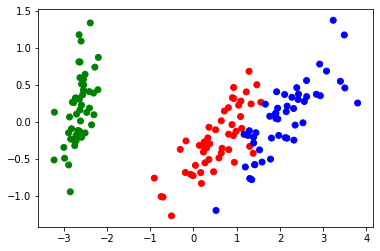

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

d = {0:'green', 1:'red', 2:'blue'}
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[d[y] for y in Y])

In [6]:
from sklearn import svm
from sklearn.metrics import accuracy_score

for c1 in [0, 1, 2]:
    for c2 in range(c1 + 1, 3):
        mask_y = np.logical_or(Y == c1, Y == c2)
        Y_bin = (Y == c1).astype(int) # binarize target
        X_train, X_test, Y_train, Y_test = train_test_split(X_pca[mask_y], Y_bin[mask_y], 
                                                            test_size=0.4, random_state=12)

        model = svm.SVC(kernel='linear', C=1.0)

        model.fit(X_train, Y_train)
        y_predict = model.predict(X_test)
        print(f"Classes {c1} vs {c2}, acc={accuracy_score(Y_test, y_predict):.3f}")

Classes 0 vs 1, acc=1.000
Classes 0 vs 2, acc=1.000
Classes 1 vs 2, acc=0.950
